# 全卷积网络（FCN）

在图像分类里，我们通过卷积层和池化层逐渐减少图像高宽最终得到跟预测类别数一样长的向量。例如用于 ImageNet 分类的 ResNet-18 里，我们将高宽为 224 的输入图像首先减少到高宽 7，然后使用全局池化层得到 512 维输出，最后使用全连接层输出长为 1000 的预测向量。

但在语义分割里，我们需要对每个像素预测类别，也就是需要输出形状需要是 $1000\times 224\times 224$。如果仍然使用全连接层作为输出，那么这一层权重将多达数百 GB。本小节我们将介绍利用卷积神经网络解决语义分割的一个开创性工作之一：全卷积网络（fully convolutional network，简称 FCN）[1]。FCN 里将最后的全连接层修改成转置卷积层（transposed convolution）来得到所需大小的输出。

In [1]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import gluonbook as gb
from mxnet import gluon, image, init, nd
from mxnet.gluon import data as gdata, loss as gloss, model_zoo, nn
import numpy as np
import sys

## 转置卷积层

假设 $f$ 是一个卷积层，给定输入 $x$，我们可以计算前向输出 $y=f(x)$。在反向求导 $z=\frac{\partial\, y}{\partial\,x}$ 时，我们知道 $z$ 会得到跟 $x$ 一样形状的输出。因为卷积运算的导数是自己本身，我们可以合法定义转置卷积层，记为 $g$，为交换了前向和反向求导函数的卷积层。也就是 $z=g(y)$。

下面的例子描述我们如何将卷积计算转换成矩阵乘法。

In [2]:
X = nd.arange(1, 17).reshape((1, 1, 4, 4))
K = nd.arange(1, 10).reshape((1, 1, 3, 3))
conv = nn.Conv2D(channels=1, kernel_size=3)
conv.initialize(init.Constant(K))

conv(X), conv.weight.data()

(
 [[[[348. 393.]
    [528. 573.]]]]
 <NDArray 1x1x2x2 @cpu(0)>, 
 [[[[1. 2. 3.]
    [4. 5. 6.]
    [7. 8. 9.]]]]
 <NDArray 1x1x3x3 @cpu(0)>)

In [3]:
W, k = nd.zeros((4, 16)), nd.zeros(11)
k[:3], k[4:7], k[8:] = K[0, 0, 0, :], K[0, 0, 1, :], K[0, 0, 2, :]
W[0, 0:11], W[1, 1:12], W[2, 4:15], W[3, 5:16] = k, k, k, k
nd.dot(W, X.reshape(16)).reshape((1, 1, 2, 2)), W

(
 [[[[348. 393.]
    [528. 573.]]]]
 <NDArray 1x1x2x2 @cpu(0)>, 
 [[1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9. 0. 0. 0. 0. 0.]
  [0. 1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9. 0.]
  [0. 0. 0. 0. 0. 1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9.]]
 <NDArray 4x16 @cpu(0)>)

下面我们构造一个卷积层并打印它的输出形状。

In [4]:
conv = nn.Conv2D(10, kernel_size=4, padding=1, strides=2)
conv.initialize()

X = nd.random.uniform(shape=(1, 3, 64, 64))
Y = conv(X)
Y.shape

(1, 10, 32, 32)

使用同样的卷积窗、填充和步幅的转置卷积层，我们可以得到和`x`形状一样的输出。

In [5]:
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)
conv_trans.initialize()
conv_trans(Y).shape

(1, 3, 64, 64)

简单来说，卷积层通常使得输入高宽变小，而转置卷积层则一般用来将高宽增大。

## FCN 模型

FCN 的核心思想是将一个卷积网络的最后全连接输出层替换成转置卷积层来获取对每个输入像素的预测。具体来说，它去掉了过于损失空间信息的全局池化层，并将最后的全连接层替换成输出通道是原全连接层输出大小的 $1\times 1$ 卷积层，最后接上转置卷积层来得到需要形状的输出。图 9.11 描述了 FCN 模型。

![FCN模型。](../img/fcn.svg)

下面我们基于 ResNet-18 来创建 FCN。首先我们下载一个预先训练好的模型，并打印其最后的数个神经层。

In [6]:
pretrained_net = model_zoo.vision.resnet18_v2(pretrained=True)
pretrained_net.features[-4:], pretrained_net.output

([BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=512),
  Activation(relu),
  GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True),
  Flatten],
 Dense(512 -> 1000, linear))

可以看到`feature`模块最后两层是`GlobalAvgPool2D`和`Flatten`，在 FCN 里均不需要，`output`模块里的全连接层也需要舍去。下面我们定义一个新的网络，它复制`feature`里除去最后两层的所有神经层以及权重。

In [7]:
net = nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
    net.add(layer)

给定高宽为 224 的输入，`net`的输出将减少为输入高宽的 $1/32$。

In [8]:
X = nd.random.uniform(shape=(1, 3, 224, 224))
net(X).shape

(1, 512, 7, 7)

为了使得输出跟输入有同样的高宽，我们构建一个步幅为 32 的转置卷积层，卷积核的窗口高宽设置成步幅的 2 倍，并补充适当的填充。在转置卷积层之前，我们加上 $1\times 1$ 卷积层来将通道数从 512 降到标注类别数，对 Pascal VOC 数据集来说是 21。

In [9]:
num_classes = 21
net.add(nn.Conv2D(num_classes, kernel_size=1),
        nn.Conv2DTranspose(num_classes, kernel_size=64, padding=16,
                           strides=32))

## 模型初始化

模型`net`中的最后两层需要对权重进行初始化，通常我们会使用随机初始化。但新加入的转置卷积层的功能有些类似于将输入调整到更大的尺寸。在图像处理里面，我们可以通过有适当卷积核的卷积运算符来完成这个操作。常用的包括双线性插值核，以下函数构造核权重。

In [10]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return nd.array(weight)

接下来我们构造一个步幅为 2 的转置卷积层，将其权重初始化为双线性插值核。

可以看到这个转置卷积层的前向函数的效果是将输入图像高宽扩大 2 倍。

In [11]:
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)
conv_trans.initialize(init.Constant(bilinear_kernel(3, 3, 4)))

img = image.imread('../img/catdog.jpg')
X = img.astype('float32').transpose((2, 0, 1)).expand_dims(axis=0) / 255
Y = conv_trans(X)
out_img = Y[0].transpose((1, 2, 0))

input image shape: (561, 728, 3)


output image shape: (1122, 1456, 3)


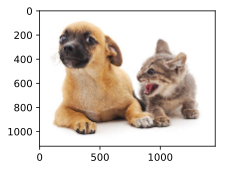

In [12]:
gb.set_figsize()
print('input image shape:', img.shape)
gb.plt.imshow(img.asnumpy());
print('output image shape:', out_img.shape)
gb.plt.imshow(out_img.asnumpy());

下面对`net`的最后两层进行初始化。其中 $1\times 1$ 卷积层使用 Xavier，转置卷积层则使用双线性插值核。

In [13]:
trans_conv_weights = bilinear_kernel(num_classes, num_classes, 64)
net[-1].initialize(init.Constant(trans_conv_weights))
net[-2].initialize(init=init.Xavier())

## 读取数据

我们使用较大的输入图像尺寸，其值选成了 32 的倍数。数据的读取方法已在上一节描述。

In [14]:
input_shape, batch_size, colormap2label = (320, 480), 32, nd.zeros(256**3)
for i, cm in enumerate(gb.VOC_COLORMAP):
    colormap2label[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i
voc_dir = gb.download_voc_pascal(data_dir='../data')

num_workers = 0 if sys.platform.startswith('win32') else 4
train_iter = gdata.DataLoader(
    gb.VOCSegDataset(True, input_shape, voc_dir, colormap2label), batch_size,
    shuffle=True, last_batch='discard', num_workers=num_workers)
test_iter = gdata.DataLoader(
    gb.VOCSegDataset(False, input_shape, voc_dir, colormap2label), batch_size,
    last_batch='discard', num_workers=num_workers)

read 1114 examples


read 1078 examples


## 训练

这时候我们可以开始训练了。因为我们使用转置卷积层的通道来预测像素的类别，所以 softmax 是作用在通道这个维度（维度 1）上的。于是，我们在`SoftmaxCrossEntropyLoss`里加入了额外的`axis=1`选项。

In [15]:
ctx = gb.try_all_gpus()
loss = gloss.SoftmaxCrossEntropyLoss(axis=1)
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1,
                                                      'wd': 1e-3})
gb.train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs=5)

training on [gpu(0), gpu(1), gpu(2), gpu(3), gpu(4), gpu(5), gpu(6), gpu(7)]


epoch 1, loss 1.4494, train acc 0.715, test acc 0.798, time 33.0 sec


epoch 2, loss 0.8274, train acc 0.778, test acc 0.816, time 19.2 sec


epoch 3, loss 0.6905, train acc 0.806, test acc 0.822, time 21.0 sec


epoch 4, loss 0.6325, train acc 0.816, test acc 0.824, time 20.2 sec


epoch 5, loss 0.5922, train acc 0.830, test acc 0.827, time 21.2 sec


## 预测

预测一张新图像时，我们只需要将其归一化并转成卷积网络需要的 4D 格式。

In [16]:
def predict(img):
    x = test_iter._dataset.normalize_image(img)
    x = x.transpose((2, 0, 1)).expand_dims(axis=0)
    pred = nd.argmax(net(x.as_in_context(ctx[0])), axis=1)
    return pred.reshape((pred.shape[1], pred.shape[2]))

同时我们根据每个像素预测的类别找出其 RGB 颜色以便画图。

In [17]:
def label2image(pred):
    colormap = nd.array(gb.VOC_COLORMAP, ctx=ctx[0], dtype='uint8')
    x = pred.astype('int32')
    return colormap[x, :]

现在我们读取前几张测试图像并对其进行预测。

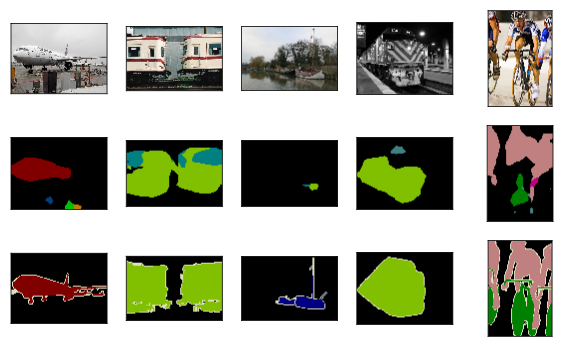

In [18]:
test_images, test_labels = gb.read_voc_images(is_train=False)
n, imgs = 5, []
for i in range(n):
    X = test_images[i]
    pred = label2image(predict(X))
    imgs += [X, pred, test_labels[i]]
gb.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n);

## 小结

* FCN 通过转置卷积层来为每个像素预测类别。

## 练习

* 试着改改最后的转置卷积层的参数设定。
* 看看双线性插值初始化是不是必要的。
* 试着改改训练参数来使得收敛更好些。
* FCN 论文中提到了不只是使用主体卷积网络输出，还可以考虑其中间层的输出 [1]。试着实现这个想法。

## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/3041)

![](../img/qr_fcn.svg)


## 参考文献

[1] Long, J., Shelhamer, E., & Darrell, T. (2015). Fully convolutional networks for semantic segmentation. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 3431-3440).